In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../novelgraphs/'))

import novelgraphs as ng

import pandas as pd
from collections import defaultdict, Counter
from itertools import combinations
import networkx as nx
from operator import itemgetter
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from numpy import array_split
import numpy

In [2]:
# text = pd.read_pickle('fight_text.pickle')
# text = pd.read_pickle('table.pickle')
text = ng.Text.from_pickle('table.pickle')

In [3]:
text.tags.head()

,SentenceID,TokenID,Token,Lemma,Pos,NER,DepParse,DepRel,NerNpID,Sentiment,QuotationID,DialogID,CharacterID
0,0,0,A,a,DT,O,1,det,None,NaN,None,None,None
1,0,1,STUDY,study,NN,O,-1,ROOT,None,NaN,None,None,None
2,0,2,IN,in,IN,O,4,case,None,NaN,None,None,None
3,0,3,SCARLET,scarlet,NNP,O,4,compound,None,NaN,None,None,None
4,0,4,Table,table,NNP,O,1,nmod:in,None,NaN,None,None,None


In [4]:
core = ng.annotators.CoreNLP()
np = ng.annotators.NerNpID()
ann = ng.annotators.Sentiment()
ann2 = ng.annotators.Dialog()
qq = ng.annotators.Quote()
fp = ng.annotators.FirstPerson()
char = ng.annotators.Character()

In [6]:
# pipeline = ng.annotators.Pipeline([ann, qq, ann2, fp, char])
# pipeline.annotate(text)

In [5]:
dialog = ng.interaction.extractors.Dialog()
sentences = ng.interaction.extractors.Sentences()
sent_dist = ng.interaction.extractors.SentenceDistance()
tokens = ng.interaction.extractors.TokenDistance()
seq = ng.interaction.extractors.TokenSequence()
dep = ng.interaction.extractors.TokenDependencies()

count = ng.interaction.aggregators.Count()
sentiment = ng.interaction.aggregators.Sentiment()

In [57]:
novelgraph = ng.NovelGraph(dialog, sentiment)
graph = novelgraph(text)

In [69]:
def graph_weights(graph):
    return [edge[2]['weight'] for edge in graph.edges(data=True)]

weights = graph_weights(graph)

# plt.figure(figsize=(10,10))
# plt.axis('off')
# nx.draw_networkx(graph,
#                  with_labels=True,
#                  edge_color=weights,
#                  edge_cmap=plt.cm.coolwarm,
#                  edge_vmax = 0.5, edge_vmin=-0.5, alpha=0.6)

### Rolling window

In [8]:
def rolling_window_slices(window_size, step, length):
    if length <= 18000:
        window_size = 3000
        step = 1000
    
    num_slices = max((length - window_size) // step, 0)
    return ([slice(i * step, i * step + window_size) for i in range(num_slices)] +
             [slice(num_slices * step, length)])

In [9]:
rolling_window_slices(10000, 2000, len(text.tags))[:5]

[slice(0, 10000, None),
 slice(2000, 12000, None),
 slice(4000, 14000, None),
 slice(6000, 16000, None),
 slice(8000, 18000, None)]

### Negative graph plot

In [ ]:
# num_chapters = 10

# chapters = []
# for tags in array_split(text.tags, num_chapters):
#     chapter = ng.Text('')
#     chapter.characters = text.characters
#     chapter.first_person = text.first_person
#     chapter.tags = tags
#     chapters.append(chapter)

In [10]:
def get_chapters(window_size, step, length):
    chapters = []
    for slice_t in rolling_window_slices(window_size, step, length):
        tags = text.tags.loc[slice_t]
        chapter = ng.Text('')
        chapter.characters = text.characters
        chapter.first_person = text.first_person
        chapter.tags = tags
        chapters.append(chapter)
    return chapters

In [70]:
chapters = get_chapters(10000, 500, len(text.tags))

In [71]:
def get_negative_sentiment_balance(chapters):
    text_balance = []
    for i in range(len(chapters)):
        graph = novelgraph(chapters[i])
        weights = graph_weights(graph)
        if weights:
            balance = len([p for p in weights if p < 0]) / len(weights)
            text_balance.append(balance)
    return text_balance

In [72]:
negative_graph = get_negative_sentiment_balance(chapters)

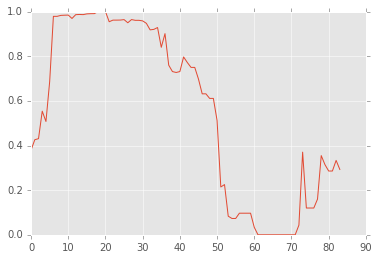

In [73]:
plt.plot(negative_graph)

- Мера сбалансированности: отношение значений < 0 ко всем значениям => чем ближе к 1, тем несбалансированней, чем ближе к 0 - тем ближе к балансу
    - tokens
    - sentences
    
- Seq и Dep могут оказаться пустыми!
    - seq периодически вылетает с ошибкой (добавить проверку i + 2 < len(text))
- количество "глав" должно быть разным для разных произведений (например, для коротких - 5, для длинных - больше)
- 10 хорошее количество глав, но лучше двигаться скользящим окном
- вопрос с nan

### Balanced graph plot

In [79]:
def get_cycles_from_graph(graph):
    cycles = []
    for cycle in nx.cycle_basis(graph):
        cycles.append(list(zip(cycle, cycle[1:])) + [(cycle[-1], cycle[0])])
    return cycles

def is_positive(cycle, graph):
    negatives = 0
    for edge in cycle:
        if graph.edge[edge[0]][edge[1]]['weight'] < 0:
            negatives += 1
    return not negatives % 2

def get_graph_balance(chapters):
    '''Считаем сбалансированность графа: 
    1. выделить простые циклы из графа
    2. определить знак цикла
    3. находим меру сбалансированности - долю положительных циклов среди всех
    '''
    balance_cycle = []
    for i in range(len(chapters)):
        graph = novelgraph(chapters[i])
        graph_cycles = get_cycles_from_graph(graph)
#         print(len(graph_cycles))
        balance = numpy.mean(
            [is_positive(cycle, graph) for cycle in graph_cycles])
        balance_cycle.append(balance)
#     print(balance_cycle) 
    return balance_cycle

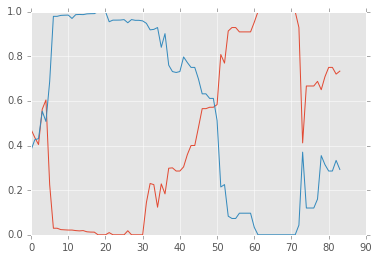

In [80]:
balance = get_graph_balance(chapters)
plt.plot(balance, label='Balance')
plt.plot(negative_graph, label='Negative_sent')
# plt.legend()